In [17]:
import h5py
from astropy.table import Table, QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip, mad_std
from dask import delayed
from tqdm.auto import tqdm, trange
import xarray as xr
import warnings
import shutil
import logging as log
from dask.distributed import LocalCluster, Client
import pandas as pd


In [1]:
from sdhdf_xarray import get_subbands, create, flag_persistent, flag_auto, decimate
import matplotlib.pyplot as plt

In [2]:
filename = "/Users/tho822/data/parkes/uwl_220614_081115.hdf"
dataset = create(filename, in_memory=True)

Reading beams:   0%|          | 0/1 [00:00<?, ?it/s]

Reading subbands:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
dataset_pflag = flag_persistent(dataset)

Flagging persistent RFI:   0%|          | 0/31 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

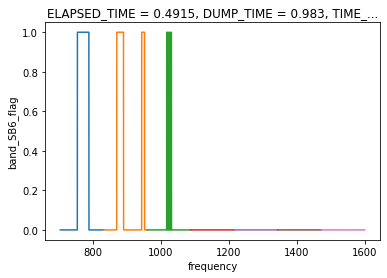

In [5]:
flag_sbs = [sb for sb in dataset_pflag.keys() if "flag" in sb]
for sb in flag_sbs:
    dataset_pflag[sb].isel(polarization=0, time=0, bin=0).plot()

In [4]:
dataset_aflag = flag_auto(dataset_pflag, sigma=3, n_windows=100)

Flagging subbands:   0%|          | 0/7 [00:00<?, ?it/s]

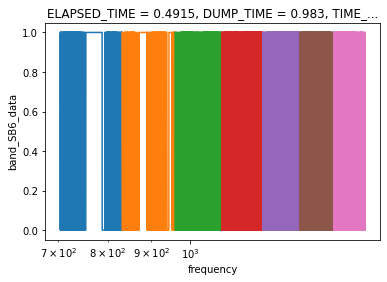

In [14]:
flag_sbs = [sb for sb in dataset_aflag.keys() if "flag" in sb]
for sb in flag_sbs:
    dataset_aflag[sb].isel(polarization=0, time=0, bin=0).plot()
plt.xscale("log")

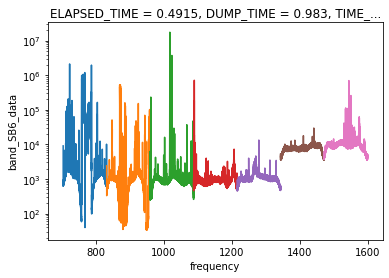

In [15]:
data_sbs = [sb for sb in dataset_aflag.keys() if "data" in sb]
for sb in data_sbs:
    # Get the data
    dat = dataset_aflag[sb]
    dat.isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

In [7]:
from sdhdf_xarray import _decimate_data

In [14]:
from tqdm import tqdm

In [15]:
# Iterate through each subband
dataset_dec = dataset_aflag.copy()
# Iterate through each subband
data_sbs = [sb for sb in dataset.keys() if "data" in sb]
for sb in tqdm(data_sbs, desc="Decimating subbands"):
    # Get the data
    dat = dataset[sb]
    # Set chunks for parallel processing
    chunks = {d:1 for d in dat.dims}
    chunks["frequency"] = len(dat.frequency)
    dat = dat.chunk(chunks)
    flag = dataset[sb.replace("data", "flag")]
    flag = flag.chunk(chunks)
    break

Decimating subbands:   0%|          | 0/7 [00:01<?, ?it/s]


In [18]:
def _decimate_data(dat: np.ndarray, flag:np.ndarray, nchan: int=1024) -> xr.DataArray:
    """
    Decimate a dataset.
    """
    # Determine the number of channels average at time
    current_nchan = len(dat)
    nchan_avg = int(current_nchan / nchan)
    # Average the masked data
    dat = np.ma.array(dat, mask=flag)
    dat_avg = np.ma.mean(dat.reshape((nchan, nchan_avg)), axis=1)
    return dat_avg.data, dat_avg.mask

In [40]:
in_shape = list(dat.shape)
out_shape = list(dat.shape)
idx = out_shape.index(len(dat.frequency))
out_shape[idx] = 1024
dat_dec, flag_dec = xr.apply_ufunc(
    _decimate_data,
    dat,
    flag,
    input_core_dims=[["frequency"], ["frequency"]],
    output_core_dims=[["frequency"], ["frequency"]],
    exclude_dims={"frequency"},
    kwargs={"nchan": 1024},
    dask="parallelized",
    # vectorize=True,
    output_dtypes=(float, bool),
    dask_gufunc_kwargs={"output_sizes": {"frequency": 1024}},
)

In [43]:
dat_dec.compute()

ValueError: cannot reshape array of size 262144 into shape (1024,0)

In [44]:
seps

NameError: name 'seps' is not defined

In [7]:
dataset_dec = decimate(dataset_aflag, nchan=1024)

Decimating subbands:   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
dataset_dec[sb].compute()

ValueError: cannot reshape array of size 262144 into shape (1024,0)

In [8]:
data_sbs = [sb for sb in dataset_dec.keys() if "data" in sb]
for sb in data_sbs:
    # Get the data
    dat = dataset_dec[sb]
    dat.isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

ValueError: cannot reshape array of size 262144 into shape (1024,0)

In [27]:
from tqdm.auto import tqdm

In [35]:
%matplotlib widget

In [83]:
# for  in tqdm(data_sbs):
# plt.figure()
sb = data_sbs[0]
# Get the data
dat = dataset_aflag[sb]
flag = dataset_aflag[sb.replace("data", "flag")]
dat_flg = dat.where(
    ~flag.astype(bool),
)
dat = dat.isel(polarization=0, time=0, bin=0)
flag = flag.isel(polarization=0, time=0, bin=0)
# dat_flg.isel(polarization=1, time=0, bin=0).plot(c="r")
# dat.isel(polarization=0, time=0, bin=0).plot(c="k", alpha=0.1)
# dat.isel(polarization=1, time=0, bin=0).plot(c="r", alpha=0.1)
# plt.yscale("log")

In [62]:
import numpy as np

In [76]:
np.ma.array(dat, mask=flag)

masked_array(data=[--, 762.7642822265625, 712.7318115234375, ...,
                   722.1639404296875, 818.422607421875, 730.5523681640625],
             mask=[ True, False, False, ..., False, False, False],
       fill_value=1e+20,
            dtype=float32)

In [85]:
nchan = 1024
current_nchan = len(dat)
nchan_avg = int(current_nchan / nchan)
dat = np.ma.array(dat, mask=flag)
dat_avg = np.ma.mean(dat.reshape((nchan, nchan_avg)), axis=1)

In [84]:
dat.reshape((nchan, nchan_avg))

AttributeError: 'DataArray' object has no attribute 'reshape'

In [92]:
from sdhdf_xarray import decimate

ImportError: cannot import name 'decimate' from 'sdhdf_xarray' (/Users/tho822/GoogleDrive/repos/atflagger/sdhdf_xarray.py)

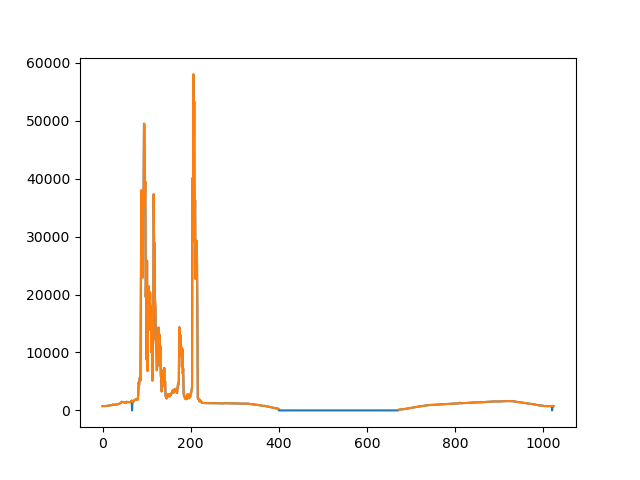

In [91]:
plt.figure()
plt.plot(dat_avg.data)
plt.plot(dat_avg)

  0%|          | 0/7 [00:00<?, ?it/s]

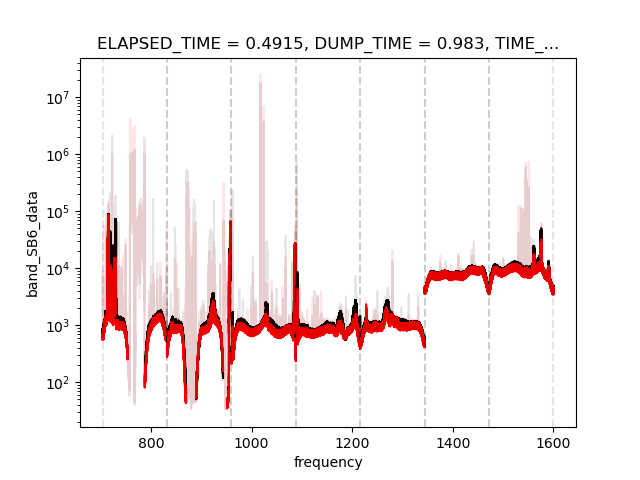

In [46]:

data_sbs = [sb for sb in dataset_aflag.keys() if "data" in sb]
for sb in tqdm(data_sbs):
    # Get the data
    dat = dataset_aflag[sb]
    flag = dataset_aflag[sb.replace("data", "flag")]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    dat_flg.isel(polarization=0, time=0, bin=0).plot(c="k")
    dat_flg.isel(polarization=1, time=0, bin=0).plot(c="r")
    dat.isel(polarization=0, time=0, bin=0).plot(c="k", alpha=0.1)
    dat.isel(polarization=1, time=0, bin=0).plot(c="r", alpha=0.1)
    plt.axvline(dat.frequency[0], c="k", alpha=0.1, linestyle="--")
    plt.axvline(dat.frequency[-1], c="k", alpha=0.1, linestyle="--")
plt.yscale("log")

<xarray.DataArray 'frequency' ()>
array(0.00048828)
Coordinates:
    beam     <U6 'beam_0'

In [11]:
rfi_df = pd.read_csv(
    "persistentRFI.dat", 
    sep=",",
    comment="#",
    names=["type", "observatory label", "receiver label", "freq0 MHz", "freq1 MHz", "MJD0", "MJD1", "text string for label",]
)

In [28]:
flag_sbs = [sb for sb in dataset.keys() if "flag" in sb]
for i, row in rfi_df.iterrows():
    for sb in flag_sbs:
        # Get the data
        flag = dataset[sb]#.astype(bool)
        mask = (
            (flag.frequency > row["freq0 MHz"]) 
            & (flag.frequency < row["freq1 MHz"])
            & (flag.MJD > row["MJD0"])
            & (flag.MJD < row["MJD1"])
        )
        dataset[sb] = xr.where(mask, 1, flag)

In [27]:
row["MJD1"]

999999

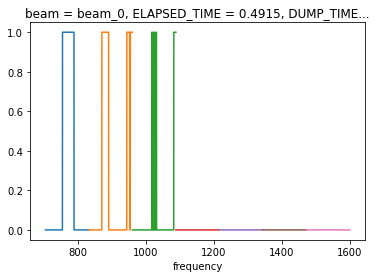

In [18]:
flag.sel(
    ,
)

ValueError: the first argument to .sel must be a dictionary

In [16]:
flag[(flag.frequency > row["freq0 MHz"]) & (flag.frequency < row["freq1 MHz"])]

IndexError: Boolean array size 1835008 is used to index array with shape (121,).

In [3]:
def get_subbands(filename, beam_label="beam_0"):
    with h5py.File(filename, "r") as h5:
        # Read header info
        sb_avail = Table.read(h5, path=beam_label + "/metadata/band_params")
    return sb_avail["LABEL"]

In [4]:
with h5py.File(filename, "r") as h5:
    keys = list(h5.keys())
    beam_labels = [key for key in keys if "beam_" in key]

    sb_avail = {}
    for beam_label in beam_labels:
        sb_avail[beam_label] = get_subbands(
            filename, beam_label=beam_label
        )

    data_arrs = []
    for beam_label in beam_labels:
        sb_labels = sb_avail[beam_label]
        for sb_label in sb_labels:
            sb_data = f"{beam_label}/{sb_label}/astronomy_data/data"
            sb_freq = f"{beam_label}/{sb_label}/astronomy_data/frequency"
            sb_para = f"{beam_label}/{sb_label}/metadata/obs_params"
            has_flags = "flag" in h5[f"{beam_label}/{sb_label}/astronomy_data"].keys()
            data = h5[sb_data]
            if has_flags:
                flag = h5[f"{beam_label}/{sb_label}/astronomy_data/flag"]
                # Ensure flag has same shape as data
                flag_reshape = flag.astype(bool).copy()
                for i, s in enumerate(data.shape):
                    if i > len(flag_reshape.shape) -1:
                        flag_reshape = np.expand_dims(flag_reshape, axis=-1)
                    else:
                        if flag_reshape.shape[i] == s:
                            continue
                        else:
                            flag_reshape = np.expand_dims(flag_reshape, axis=i)
                flag = flag_reshape
            else:
                flag = np.zeros_like(data).astype(bool)
            freq = h5[sb_freq]
            meta = h5[sb_para]
            names = meta.dtype.names
            coords = {name: ("time", meta[name]) for name in names}
            coords["frequency"] = freq
            coords["beam"] = beam_label
            data_xr = xr.DataArray(
                data,
                dims=h5[sb_data].attrs["DIMENSION_LABELS"],
                coords=coords,
                name=f"{sb_label}_data",
            )
            data_arrs.append(data_xr)
            flag_xr = xr.DataArray(
                flag.astype(bool),
                dims=h5[sb_data].attrs["DIMENSION_LABELS"],
                coords=coords,
                name=f"{sb_label}_flag",
            )
            data_arrs.append(flag_xr)
        dataset = xr.combine_by_coords(data_arrs)


In [20]:
for sb in dataset.data_vars:
    # Get the data
    if "data" in sb:
        dat = dataset[sb]
    elif "flag" in sb:
        flag = dataset[sb]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    break

In [22]:
chunks = {d:1 for d in dat_flg.dims}
chunks["frequency"] = len(dat_flg.frequency)

In [23]:
dat_flg = dat_flg.chunk(chunks)

In [24]:
def box_filter(spectrum: np.ndarray, sigma=3, n_windows=100) -> np.ndarray:
    """
    Filter a spectrum using a box filter.
    """
    # Divide spectrum into windows
    window_size = len(spectrum) // n_windows
    dat_filt = np.zeros_like(spectrum).astype(bool)
    # Iterate through windows
    for i in range(n_windows):
        _dat = spectrum[i * window_size : window_size + i * window_size]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # Use sigma clipping to remove outliers
            _dat_filt = sigma_clip(
                _dat, sigma=sigma, maxiters=None, stdfunc=mad_std, masked=True
            )
        dat_filt[i * window_size : window_size + i * window_size] = _dat_filt.mask
    return dat_filt

In [25]:
mask = xr.apply_ufunc(
    box_filter,
    dat_flg,
    input_core_dims=[["frequency"]],
    output_core_dims=[["frequency"]],
    kwargs={"sigma": 3, "n_windows": 100},
    dask="parallelized",
    vectorize=True,
    output_dtypes=(bool),
)

In [43]:
dataset_filt = dataset.copy()
# Iterate through each subband
data_sbs = [sb for sb in dataset.data_vars if "data" in sb]
for sb in data_sbs:
    # Get the data
    dat = dataset[sb]
    flag = dataset[sb.replace("data", "flag")]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    # Set chunks for parallel processing
    chunks = {d:1 for d in dat_flg.dims}
    chunks["frequency"] = len(dat_flg.frequency)
    dat_flg = dat_flg.chunk(chunks)
    mask = xr.apply_ufunc(
        box_filter,
        dat_flg,
        input_core_dims=[["frequency"]],
        output_core_dims=[["frequency"]],
        kwargs={"sigma": 3, "n_windows": 100},
        dask="parallelized",
        vectorize=True,
        output_dtypes=(bool),
    )
    dataset_filt[sb.replace("data", "flag")] = mask

In [44]:
dataset_filt

,Array,Chunk
Bytes,847.00 MiB,1.75 MiB
Shape,"(121, 4, 1, 1835008)","(1, 1, 1, 1835008)"
Count,2420 Tasks,484 Chunks
Type,bool,numpy.ndarray
,Array,Chunk
Bytes,847.00 MiB,1.75 MiB
Shape,"(121, 4, 1, 1835008)","(1, 1, 1, 1835008)"
Count,2420 Tasks,484 Chunks
Type,bool,numpy.ndarray
,Array,Chunk


In [13]:
flag_sbs = [sb for sb in dataset.data_vars if "flag" in sb]

In [14]:
flag_sbs

['band_SB0_flag',
 'band_SB1_flag',
 'band_SB2_flag',
 'band_SB3_flag',
 'band_SB4_flag',
 'band_SB5_flag',
 'band_SB6_flag']

In [29]:
dims = list(dat_flg.dims)
dims.remove("frequency")

In [30]:
mask_red = mask.sum(dim=dims) > 0

In [34]:
mask.compute().shape

(121, 4, 1, 1835008)

In [35]:
flag.shape

(121, 4, 1835008, 1)

In [103]:
with h5py.File(filename, "r") as h5:
    # h5.visititems(print)
    print(h5[f"{beam_label}/{sb_label}"].keys())

<KeysViewHDF5 ['astronomy_data', 'metadata']>


In [73]:
dataset.frequency

<xarray.DataArray 'frequency' (frequency: 1835008)>
array([ 704.000244,  704.000732,  704.001221, ..., 1599.998779, 1599.999268,
       1599.999756])
Coordinates:
  * frequency  (frequency) float64 704.0 704.0 704.0 ... 1.6e+03 1.6e+03 1.6e+03
    beam       <U6 'beam_0'

In [74]:
data_sbs = [sb for sb in dataset_filt.data_vars if "data" in sb]
for sb in data_sbs:
    dat = dataset[sb]
    flag = dataset[sb.replace("data", "flag")]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    plt.plot(dat_flg.isel(polarization=0, bin=0).DEC_DEG, dat_flg.isel(polarization=0, bin=0))
plt.yscale("log")

KeyboardInterrupt: 

: 

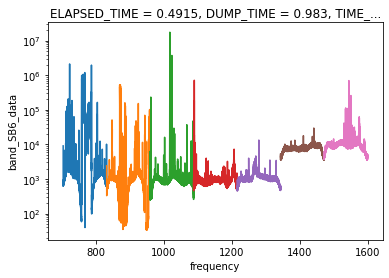

In [49]:
data_sbs = [sb for sb in dataset_filt.data_vars if "data" in sb]
for sb in data_sbs:
    # Get the data
    dat = dataset[sb]
    flag = dataset[sb.replace("data", "flag")]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    dat_flg.isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

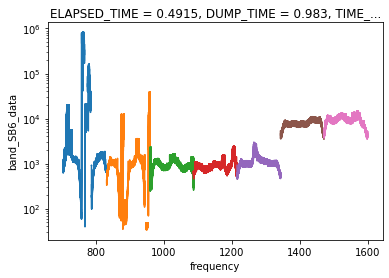

In [50]:
data_sbs = [sb for sb in dataset_filt.data_vars if "data" in sb]
for sb in data_sbs:
    # Get the data
    dat = dataset_filt[sb]
    flag = dataset_filt[sb.replace("data", "flag")]
    dat_flg = dat.where(
        ~flag.astype(bool),
    )
    dat_flg.isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

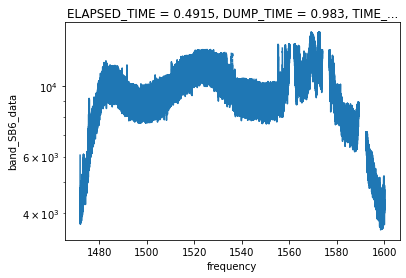

In [53]:
sb = data_sbs[-1]
# Get the data
dat = dataset_filt[sb]
flag = dataset_filt[sb.replace("data", "flag")]
dat_flg = dat.where(
    ~flag.astype(bool),
)
dat_flg.isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

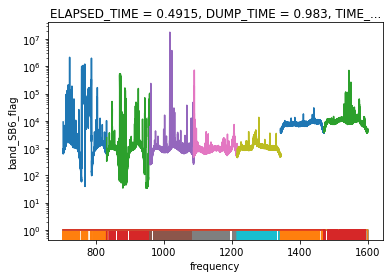

In [48]:
for d in dataset_filt.data_vars:
    dataset_filt[d].isel(polarization=0, time=0, bin=0).plot()
plt.yscale("log")

KeyboardInterrupt: 

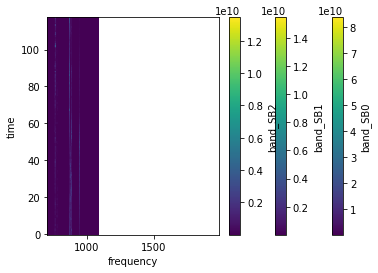

In [57]:
for d in dataset.data_vars:
    dataset[d].isel(polarization=0, beam=0, bin=0).plot.imshow()

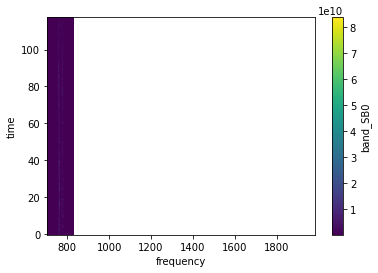

In [58]:
dataset.band_SB0.isel(polarization=0, beam=0, bin=0).plot.imshow()

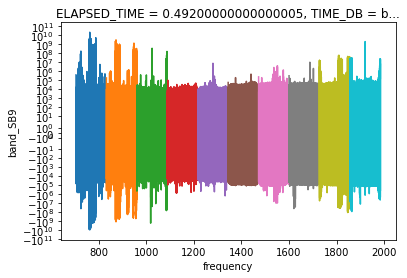

In [55]:
for d in dataset.data_vars:
    dataset[d].isel(polarization=2, time=0, beam=0, bin=0).plot()
plt.yscale("symlog")

In [59]:
Table.read("persistentRFI.dat", format="ascii")

InconsistentTableError: 
ERROR: Unable to guess table format with the guesses listed below:
Reader:Ecsv fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:FixedWidthTwoLine fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:RST fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:FastBasic fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Basic fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:FastRdb fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Rdb fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:FastTab fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Tab fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Cds fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Daophot fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:SExtractor fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Ipac fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:Latex fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:AASTex fast_reader: {'enable': True} fill_values: [('', '0')] strict_names: True
Reader:FastCommentedHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastCommentedHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastCommentedHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastCommentedHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastCommentedHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastCommentedHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastCommentedHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastCommentedHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:CommentedHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:CommentedHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:CommentedHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:CommentedHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:CommentedHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:CommentedHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:CommentedHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:CommentedHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastBasic delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastBasic delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastBasic delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastBasic delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastBasic delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastBasic delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastBasic delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastBasic delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:Basic delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:Basic delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:Basic delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:Basic delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:Basic delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:Basic delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:Basic delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:Basic delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastNoHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastNoHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastNoHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastNoHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastNoHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastNoHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:FastNoHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:FastNoHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:NoHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:NoHeader delimiter: '|' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:NoHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:NoHeader delimiter: ',' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:NoHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:NoHeader delimiter: ' ' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:NoHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: '"' strict_names: True
Reader:NoHeader delimiter: '\\s' fast_reader: {'enable': True} fill_values: [('', '0')] quotechar: "'" strict_names: True
Reader:Basic fast_reader: {'enable': True} fill_values: [('', '0')]

************************************************************************
** ERROR: Unable to guess table format with the guesses listed above. **
**                                                                    **
** To figure out why the table did not read, use guess=False and      **
** fast_reader=False, along with any appropriate arguments to read(). **
** In particular specify the format and any known attributes like the **
** delimiter.                                                         **
************************************************************************

In [1]:
import pandas as pd

In [12]:
for i, row in rfi_df.iterrows():
    print(row[])

type                                                                     1
observatory label                                                   Parkes
receiver label                                                         all
freq0 MHz                                                            754.0
freq1 MHz                                                            768.0
MJD0                                                                     0
MJD1                                                                999999
text string for label    Optus transmission tower (note from 754-758 we...
Name: 0, dtype: object
type                                              1
observatory label                            Parkes
receiver label                                  all
freq0 MHz                                     768.0
freq1 MHz                                     788.0
MJD0                                              0
MJD1                                         999999
text string f